In [27]:
import requests
from io import StringIO
import os
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from fredapi import Fred
import warnings
warnings.filterwarnings("ignore")

### read and clean main csv

In [28]:
#df = pd.read_csv('final_v2.csv')
df = pd.read_csv('data/final_v2.csv')
print(df.head())

                  date                                              title  \
0  1999-01-03 00:00:00  Mr Ferguson reviews last year's economic perfo...   
1  1999-01-07 00:00:00  Mr Duisenberg's opening statement at the press...   
2  1999-01-14 00:00:00  Mr Duisenberg discusses the arrival of the eur...   
3  1999-01-15 00:00:00  Mr Ferguson expresses his views on monetary po...   
4  1999-01-18 00:00:00  Mr Duisenberg's opening statement at the Europ...   

                                         description  \
0  Remarks by Mr Roger W. Ferguson, Jr., a member...   
1  Introductory statement by the President of the...   
2  Speech by the President of the European Centra...   
3  Remarks by Mr Roger W. Ferguson, Jr., a member...   
4  Introductory statement by the President of the...   

                                                text               author  \
0  Mr Ferguson reviews last year's economic perfo...     Roger W Ferguson   
1  Mr Duisenberg's opening statement at the pr

In [29]:
eu_df = df[df['country'] == 'Euro area'][['date', 'current_rate']]
print(eu_df.head())

                   date  current_rate
1   1999-01-07 00:00:00           3.0
2   1999-01-14 00:00:00           3.0
4   1999-01-18 00:00:00           3.0
8   1999-01-25 00:00:00           3.0
10  1999-02-04 00:00:00           3.0


In [30]:
# Remove duplicate rows and keep only unique rows
eu_df = eu_df.drop_duplicates()

# Convert 'date' to just yyyy-mm-dd (string)
eu_df['date'] = pd.to_datetime(eu_df['date']).dt.strftime('%Y-%m-%d')

eu_df.set_index('date', inplace=True)

print(eu_df.head())

            current_rate
date                    
1999-01-07           3.0
1999-01-14           3.0
1999-01-18           3.0
1999-01-25           3.0
1999-02-04           3.0


In [31]:
unique_dates = eu_df.index.nunique()
duplicate_dates = eu_df.index[eu_df.index.duplicated()]
print("Duplicate dates:", duplicate_dates.unique())

Duplicate dates: Index(['2004-11-11', '2007-02-26', '2007-05-21', '2009-09-30', '2009-12-18',
       '2014-05-26', '2015-05-04', '2017-09-21'],
      dtype='object', name='date')


In [32]:
# Print rows from usa_df where the index (date) is in duplicate_dates
print(eu_df.loc[eu_df.index.isin(duplicate_dates)])

            current_rate
date                    
2004-11-11          4.25
2004-11-11          4.25
2007-02-26          4.25
2007-02-26          4.25
2007-05-21          4.25
2007-05-21          4.25
2009-09-30          1.00
2009-09-30          1.00
2009-12-18          1.00
2009-12-18          1.00
2014-05-26          0.25
2014-05-26          0.25
2015-05-04          0.05
2015-05-04          0.05
2017-09-21          0.00
2017-09-21          0.00


In [33]:
# Remove duplicate rows in usa_df by keeping only the first occurrence for each date
eu_df = eu_df[~eu_df.index.duplicated(keep='first')]
print(eu_df.loc[duplicate_dates])  # Check that only the first row for each duplicate date remains

            current_rate
date                    
2004-11-11          4.25
2007-02-26          4.25
2007-05-21          4.25
2009-09-30          1.00
2009-12-18          1.00
2014-05-26          0.25
2015-05-04          0.05
2017-09-21          0.00


In [34]:
unique_dates = eu_df.index.nunique()
duplicate_dates = eu_df.index[eu_df.index.duplicated()]
print("Duplicate dates:", duplicate_dates.unique())

Duplicate dates: Index([], dtype='object', name='date')


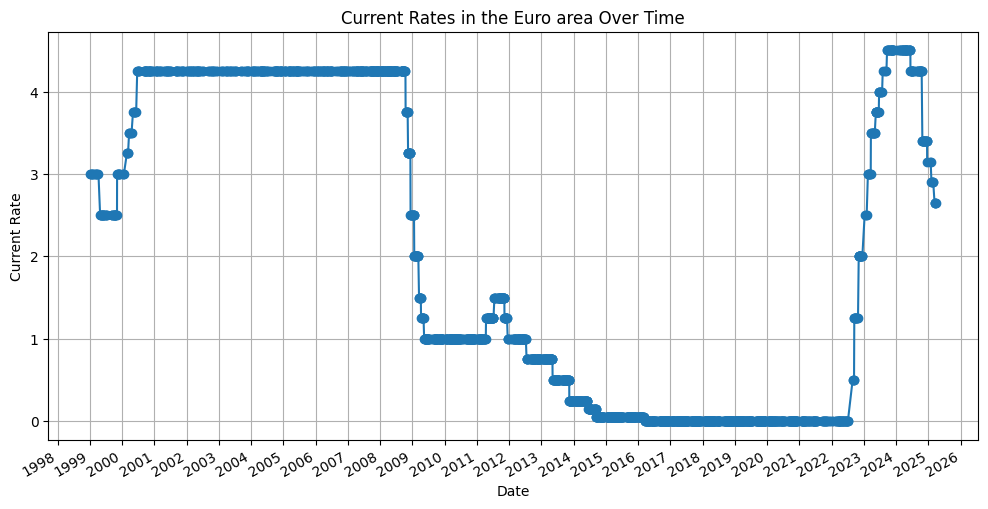

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(eu_df.index), eu_df['current_rate'], marker='o', linestyle='-')
plt.title('Current Rates in the Euro area Over Time')
plt.xlabel('Date')
plt.ylabel('Current Rate')
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()
plt.show()


In [36]:
# Ensure index is datetime and sorted
eu_df = eu_df.sort_index()
print('Tot rows in eu_df:', len(eu_df))

Tot rows in eu_df: 2039


### Read ecb data

In [37]:
# Define the CSV file paths
csv_files = {
    "sentiment_df": "data/consumer_confidence_cleaned.csv",
    "real_gdp_df": "data/gdp_clean.csv",
    "fivey_inf_df": "data/infl_exp_clean.csv",
    "inflation_df": "data/inflation_cleaned.csv",
    "oil_price_df": "data/oil_clean.csv",
    "unrate_df": "data/unemployment_clean.csv",
    "yield_spread_df": "data/yield_clean.csv"
}


# Read and process each CSV file
for var_name, file_path in csv_files.items():
    df = pd.read_csv(file_path, parse_dates=[0], index_col=0)

    # Identify the second column and convert it to integer, handling NaNs
    second_column = df.columns[0]  # Since the first column is now the index
    df[second_column] = pd.to_numeric(df[second_column], errors='coerce').fillna(0).astype(int)

    # Assign the cleaned dataframe to the respective variable name
    globals()[var_name] = df

# Example preview
print(sentiment_df.head())

            sentiment
date                 
2016-04-01        104
2016-05-01        104
2016-06-01        104
2016-07-01        104
2016-08-01        103


### Merge ecb data with main csv

In [38]:
# Extract dates from both eu_df and ecb dfs
eu_dates = eu_df.index
inflation_dates = inflation_df.index.tolist()
unrate_dates = unrate_df.index.tolist()
real_gdp_dates = real_gdp_df.index.tolist()
yield_spread_dates = yield_spread_df.index.tolist()
sentiment_dates = sentiment_df.index.tolist()
fivey_inf_dates = fivey_inf_df.index.tolist()
oil_price_dates = oil_price_df.index.tolist()

In [39]:
# Define datasets and their corresponding DataFrames
datasets = {
    'inflation': inflation_df,
    'unrate': unrate_df,
    'real_gdp': real_gdp_df,
    'yield_spread': yield_spread_df,
    'sentiment': sentiment_df,
    '5y_inflation': fivey_inf_df,
    'oil_price': oil_price_df
}

# Loop through each dataset and create new aligned DataFrames
for name, df in datasets.items():
    matched_idx = df.index.searchsorted(eu_df.index, side='right') - 1
    matched_idx = matched_idx.clip(0)  # Avoid -1 if any date in eu_df is earlier than df.index[0]
    aligned_values = df.iloc[matched_idx, 0].values  # Get the first (or only) column's values
    new_df = pd.DataFrame({name: aligned_values}, index=eu_df.index)
    globals()[f'new_{name}_df'] = new_df  # Create variable like new_inflation_df, etc.

# Example check
print(new_unrate_df.head()) #even if compiler writes it yellow as warning, it works fine


            unrate
date              
1999-01-07      10
1999-01-14      10
1999-01-18      10
1999-01-25      10
1999-02-04      10


In [40]:
# Count rows for each new dataframe
for name in datasets.keys():
    df = globals()[f'new_{name}_df']
    print(f"{name}: {len(df)} rows")

inflation: 2039 rows
unrate: 2039 rows
real_gdp: 2039 rows
yield_spread: 2039 rows
sentiment: 2039 rows
5y_inflation: 2039 rows
oil_price: 2039 rows


In [41]:
print(new_inflation_df.head())
print(eu_df.head())

            inflation
date                 
1999-01-07        103
1999-01-14        103
1999-01-18        103
1999-01-25        103
1999-02-04        103
            current_rate
date                    
1999-01-07           3.0
1999-01-14           3.0
1999-01-18           3.0
1999-01-25           3.0
1999-02-04           3.0


In [42]:
levels = eu_df.join(new_inflation_df, how='left')
print('1', len(levels))
levels = levels.join(new_unrate_df, how='left')
print('2', len(levels))
levels = levels.join(new_real_gdp_df, how='left')
print('3', len(levels))
levels = levels.join(new_yield_spread_df, how='left')
print('4', len(levels))
levels = levels.join(new_sentiment_df, how='left')
print('5', len(levels))
levels = levels.join(new_5y_inflation_df, how='left')
print('6', len(levels))
levels = levels.join(new_oil_price_df, how='left')

# Display the levels DataFrame
print("levels EU DataFrame:")
print(levels.head())
print('count rows:', len(levels))

1 2039
2 2039
3 2039
4 2039
5 2039
6 2039
levels EU DataFrame:
            current_rate  inflation  unrate  real_gdp  yield_spread  \
date                                                                  
1999-01-07           3.0        103      10         2             4   
1999-01-14           3.0        103      10         2             4   
1999-01-18           3.0        103      10         2             4   
1999-01-25           3.0        103      10         2             4   
1999-02-04           3.0        103      10         2             4   

            sentiment  5y_inflation  oil_price  
date                                            
1999-01-07        104             3         11  
1999-01-14        104             3         11  
1999-01-18        104             3         10  
1999-01-25        104             3         11  
1999-02-04        104             3         10  
count rows: 2039


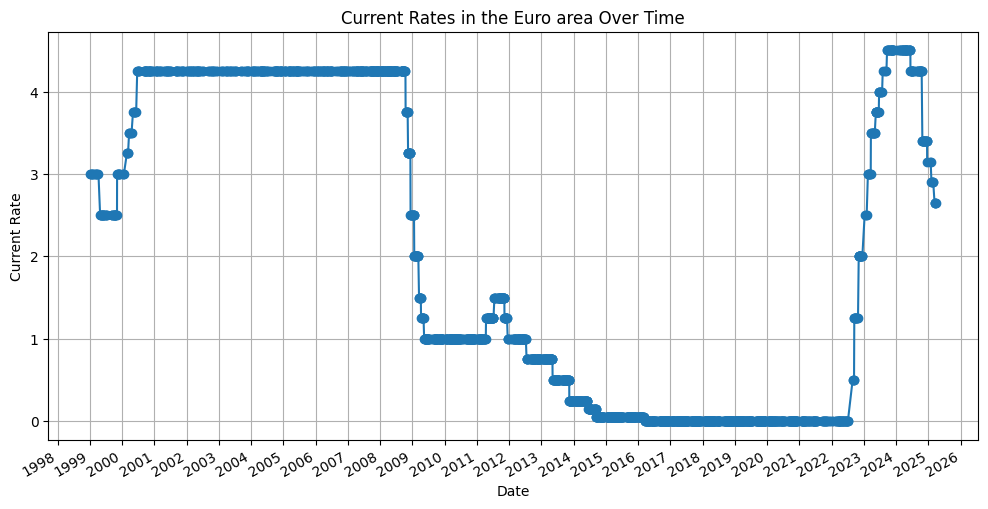

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(levels.index), levels['current_rate'], marker='o', linestyle='-')
plt.title('Current Rates in the Euro area Over Time')
plt.xlabel('Date')
plt.ylabel('Current Rate')
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()
plt.show()

### Fix stationarity

In [44]:
# Function to perform ADF test and check stationarity
def check_adf(df, column_name):
    series = df[column_name].dropna()
    result = adfuller(series)
    stationary = "Yes" if result[1] < 0.05 else "No"
    print(f"{column_name:20} ADF={result[0]: .4f}  p={result[1]: .4f}  Stationary? {stationary}")
    return stationary, result

# Function to fix stationarity for non-stationary series
def fix_stationarity(df, column_name):
    # Perform first differencing
    df[column_name] = df[column_name].diff()
    df = df.dropna()
    return df

In [45]:
# Iterate until all columns are stationary
differenced = levels.copy()
max_iter = 5  # Prevent infinite loops
for _ in range(max_iter):
    all_stationary = True
    for col in differenced.columns:
        stationary, _ = check_adf(differenced, col)
        if stationary == "No":
            differenced[col] = differenced[col].diff()
            all_stationary = False
    differenced = differenced.dropna()
    if all_stationary:
        break
    else:
        print("Not all series are stationary yet. Continuing...")

print("Final differenced DataFrame head:")
print(differenced.head())

print("Final differenced DataFrame tail:")
print(differenced.tail())

current_rate         ADF=-1.9874  p= 0.2921  Stationary? No
inflation            ADF= 1.0077  p= 0.9943  Stationary? No
unrate               ADF=-0.7941  p= 0.8209  Stationary? No
real_gdp             ADF=-4.0363  p= 0.0012  Stationary? Yes
yield_spread         ADF=-1.5949  p= 0.4861  Stationary? No
sentiment            ADF=-3.7372  p= 0.0036  Stationary? Yes
5y_inflation         ADF=-2.3902  p= 0.1445  Stationary? No
oil_price            ADF=-2.8004  p= 0.0582  Stationary? No
Not all series are stationary yet. Continuing...
current_rate         ADF=-4.4179  p= 0.0003  Stationary? Yes
inflation            ADF=-6.4312  p= 0.0000  Stationary? Yes
unrate               ADF=-45.1307  p= 0.0000  Stationary? Yes
real_gdp             ADF=-4.0708  p= 0.0011  Stationary? Yes
yield_spread         ADF=-20.5896  p= 0.0000  Stationary? Yes
sentiment            ADF=-3.7363  p= 0.0036  Stationary? Yes
5y_inflation         ADF=-10.5454  p= 0.0000  Stationary? Yes
oil_price            ADF=-16.8565  p= 0

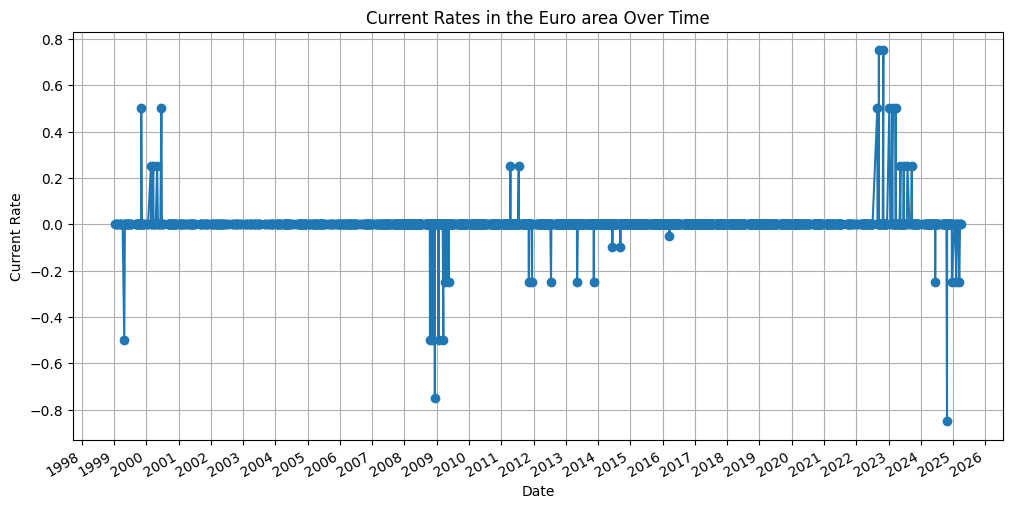

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(differenced.index), differenced['current_rate'], marker='o', linestyle='-')
plt.title('Current Rates in the Euro area Over Time')
plt.xlabel('Date')
plt.ylabel('Current Rate')
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()
plt.show()


In [47]:
print('number of rows in differenced:', len(differenced))
print('number of rows in levels:', len(levels))

number of rows in differenced: 2038
number of rows in levels: 2039


### Sarimax

In [48]:
def run_sarimax_diff(
    levels_df,                    # your original merged DataFrame
    diff_df,                      # the differenced DataFrame
    target_name='current_rate',
    test_size=350,
    order=(1,0,1),
    seasonal_order=(0,0,0,0)
):
    # 1) split diff_df into train/test
    train_diff = diff_df.iloc[:-test_size]
    test_diff  = diff_df.iloc[-test_size:]

    # Ensure both levels_df and diff_df are aligned
    levels_df = levels_df.loc[diff_df.index]

    # 2) split original levels_df at the same cutoff for undifferencing
    cutoff_idx = levels_df.shape[0] - test_size - 1
    last_level = levels_df[target_name].iloc[cutoff_idx]

    # 3) set up exogenous
    exog_vars = [c for c in diff_df.columns if c != target_name]
    exog_train = train_diff[exog_vars]
    exog_test  = test_diff[exog_vars]

    # 4) fit on diffs
    model   = SARIMAX(train_diff[target_name],
                      exog=exog_train,
                      order=order,
                      seasonal_order=seasonal_order)
    results = model.fit(disp=False)

    # 5) forecast *differences*
    fcst_diff = results.get_forecast(steps=test_size,
                                     exog=exog_test).predicted_mean

    # 6) undifference back to levels
    fcst_levels = last_level + fcst_diff.cumsum()

    # ── Key Step: align the forecast index with the test dates ─────────────
    # grab the true test index from the original levels_df
    actual_levels = levels_df[target_name].iloc[-test_size:]
    fcst_levels.index = actual_levels.index

    # 8) compute RMSE on levels
    rmse = mean_squared_error(actual_levels, fcst_levels)

    return fcst_levels, actual_levels, rmse, results

In [49]:
def plot_forecast(actual, predicted, title='Forecast'):
    plt.figure(figsize=(10, 6))
    actual.plot(label='Actual')
    predicted.plot(label='Forecast', linestyle='--')
    plt.title(title)
    plt.grid(True)
    plt.xlabel('Date')
    plt.ylabel('Rate')
    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.show()

RMSE: 5.82310141380676
Model Summary:
                               SARIMAX Results                                
Dep. Variable:           current_rate   No. Observations:                 1788
Model:               SARIMAX(1, 0, 1)   Log Likelihood                3154.795
Date:                Sun, 25 May 2025   AIC                          -6289.590
Time:                        20:33:13   BIC                          -6234.702
Sample:                             0   HQIC                         -6269.322
                               - 1788                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
inflation        0.0026      0.007      0.346      0.730      -0.012       0.017
unrate           0.0034      0.056      0.061      0.951      -0.107       0.114
real_g

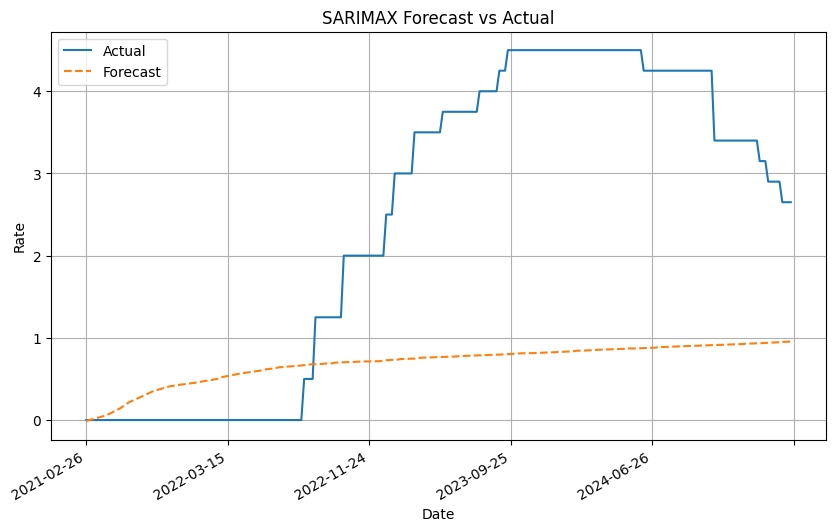

In [50]:
predicted, actual, rmse, results= run_sarimax_diff(diff_df=differenced, levels_df=levels, target_name='current_rate', test_size=250)
print(f"RMSE: {rmse}")
print(f"Model Summary:\n{results.summary()}")
plot_forecast(actual, predicted, title='SARIMAX Forecast vs Actual')

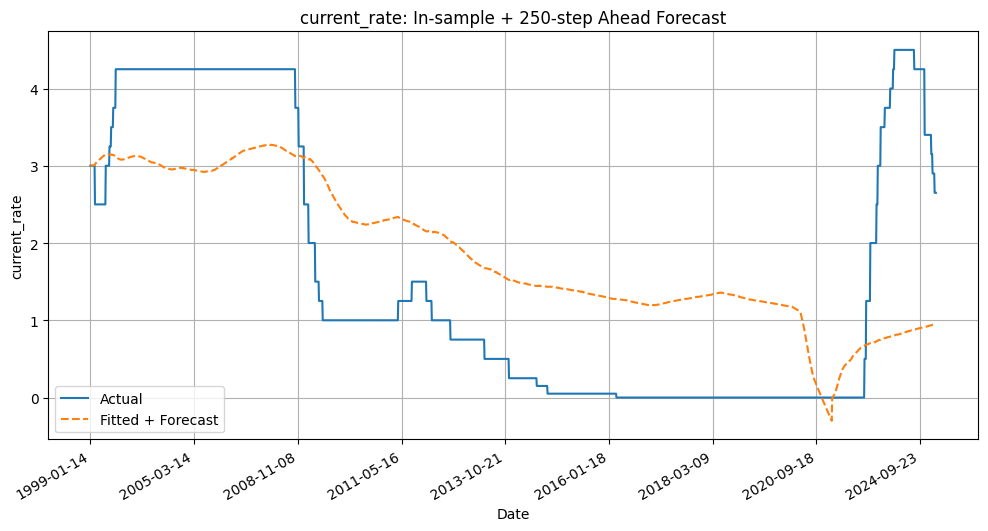

In [51]:
def plot_full_model(levels_df, diff_df, results,
                    target_name='current_rate', test_size=350):
    """
    levels_df:  original DataFrame of levels, indexed by date
    diff_df:    the first‐differenced DataFrame (levels_df.diff().dropna())
    results:    the fitted SARIMAXResults object
    test_size:  number of steps held out for forecasting
    """
    # --- 1) In‐sample fitted differences
    fitted_diff = results.fittedvalues
    # seed with the very first observed level
    init_level = levels_df[target_name].iloc[0]
    # cumulative sum to recover fitted levels
    fitted_levels = init_level + fitted_diff.cumsum()
    fitted_levels.index = fitted_diff.index

    # --- 2) Out‐of‐sample forecasted differences
    # get last observed level before the test window
    last_level = levels_df[target_name].iloc[-test_size-1]
    # pick exog for the forecast period
    exog_vars = [c for c in diff_df.columns if c != target_name]
    exog_forecast = diff_df[exog_vars].iloc[-test_size:]
    # forecast diffs
    fcst_diff = results.get_forecast(steps=test_size,
                                     exog=exog_forecast).predicted_mean
    # recover levels
    fcst_levels = last_level + fcst_diff.cumsum()
    fcst_levels.index = levels_df.index[-test_size:]

    # --- 3) Combine fitted + forecast
    pred_full = pd.concat([fitted_levels, fcst_levels])

    # --- 4) Plot
    plt.figure(figsize=(12, 6))
    levels_df[target_name].plot(label='Actual')
    pred_full.plot(label='Fitted + Forecast', linestyle='--')
    plt.title(f'{target_name}: In-sample + {test_size}-step Ahead Forecast')
    plt.xlabel('Date')
    plt.ylabel(target_name)
    plt.legend()
    plt.grid(True)
    plt.gcf().autofmt_xdate()
    plt.show()

plot_full_model(
    levels_df=levels,
    diff_df=differenced,
    results=results,
    target_name='current_rate',
    test_size=250
)

### Adding roberta

In [53]:
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
import torch

# Load model and tokenizer
model_path   = "data/roberta_2_class_best_checkpoint"
tokenizer    = RobertaTokenizerFast.from_pretrained(model_path)
model        = RobertaForSequenceClassification.from_pretrained(model_path)
device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [56]:
df        = pd.read_csv('data/final_v2.csv')
eu_df    = df[df['country']=='Euro area'][['date','clean_text']]
eu_df['date'] = pd.to_datetime(eu_df['date']).dt.strftime('%Y-%m-%d')

In [57]:
print(eu_df.head())

          date                                         clean_text
1   1999-01-07  Introductory statement by the President of the...
2   1999-01-14  Speech by the President of the European Centra...
4   1999-01-18  Introductory statement by the President of the...
8   1999-01-25  Speech by the President of the European Centra...
10  1999-02-04  Introductory statement by the President of the...


In [58]:
# Check for NaNs in the 'clean_text' column of eu_df
num_nans = eu_df['clean_text'].isna().sum()
print(f"Number of NaNs in 'clean_text': {num_nans}")

# Optionally, display the rows with NaN clean_text
print(eu_df[eu_df['clean_text'].isna()])

Number of NaNs in 'clean_text': 3
            date clean_text
3629  2018-10-17        NaN
3655  2018-11-15        NaN
4299  2022-04-06        NaN


In [59]:
eu_df['clean_text'] = eu_df['clean_text'].fillna('')

# Check for NaNs in the 'clean_text' column of eu_df
num_nans = eu_df['clean_text'].isna().sum()
print(f"Number of NaNs in 'clean_text': {num_nans}")

# Optionally, display the rows with NaN clean_text
print(eu_df[eu_df['clean_text'].isna()])

Number of NaNs in 'clean_text': 0
Empty DataFrame
Columns: [date, clean_text]
Index: []


In [60]:
# Aggregate eu_df by date, concatenating clean_text for each date
eu_df_agg = eu_df.groupby('date', as_index=False).agg({'clean_text': ' '.join})

print(eu_df_agg.head())
print('Number of unique dates:', eu_df_agg['date'].nunique())

         date                                         clean_text
0  1999-01-07  Introductory statement by the President of the...
1  1999-01-14  Speech by the President of the European Centra...
2  1999-01-18  Introductory statement by the President of the...
3  1999-01-25  Speech by the President of the European Centra...
4  1999-02-04  Introductory statement by the President of the...
Number of unique dates: 2039


In [61]:
eu_df_agg = eu_df_agg.set_index('date')
eu_df = eu_df_agg.sort_index()
print(eu_df.head())

                                                   clean_text
date                                                         
1999-01-07  Introductory statement by the President of the...
1999-01-14  Speech by the President of the European Centra...
1999-01-18  Introductory statement by the President of the...
1999-01-25  Speech by the President of the European Centra...
1999-02-04  Introductory statement by the President of the...


In [62]:
# Find duplicated index values (dates) in differenced DataFrame
duplicate_dates = eu_df.index[eu_df.index.duplicated(keep=False)]
print("Duplicate dates in eu_df:", duplicate_dates.unique())

# Show the rows with duplicate dates
print(eu_df.loc[duplicate_dates])

dates = (eu_df.index.nunique())
print(dates)

Duplicate dates in eu_df: Index([], dtype='object', name='date')
Empty DataFrame
Columns: [clean_text]
Index: []
2039


In [63]:
# 3) Run Roberta inference (batching for speed)
def get_roberta_predictions(texts, tokenizer, model, batch_size=16):
    model.eval()
    preds = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128)
        enc = {k: v.to(device) for k,v in enc.items()}
        with torch.no_grad():
            logits = model(**enc).logits
        labels = torch.argmax(logits, dim=1).cpu().numpy()
        preds.extend(labels.tolist())
    return preds

In [64]:
texts = eu_df['clean_text'].tolist()
preds = get_roberta_predictions(texts, tokenizer, model)

print(type(preds))
print(len(preds))
print(preds[:5])  # preview first few

KeyboardInterrupt: 

In [ ]:
eu_df['roberta_pred'] = preds
print('eu_df:' , eu_df.head())
print('levels:', levels.head())

print('number of rows in eu_df:', len(eu_df))
print('number of rows in levels:', len(levels))

eu_df:                                                    clean_text  roberta_pred
date                                                                       
1999-01-07  Introductory statement by the President of the...             0
1999-01-14  Speech by the President of the European Centra...             0
1999-01-18  Introductory statement by the President of the...             0
1999-01-25  Speech by the President of the European Centra...             0
1999-02-04  Introductory statement by the President of the...             0
levels:             current_rate  inflation  unrate  real_gdp  yield_spread  \
date                                                                  
1999-01-07           3.0        103      10         2             4   
1999-01-14           3.0        103      10         2             4   
1999-01-18           3.0        103      10         2             4   
1999-01-25           3.0        103      10         2             4   
1999-02-04           3.0   

In [ ]:
levels_with_roberta = levels.merge(eu_df, on="date", how="left")
print(levels_with_roberta.head())

            current_rate  inflation  unrate  real_gdp  yield_spread  \
date                                                                  
1999-01-07           3.0        103      10         2             4   
1999-01-14           3.0        103      10         2             4   
1999-01-18           3.0        103      10         2             4   
1999-01-25           3.0        103      10         2             4   
1999-02-04           3.0        103      10         2             4   

            sentiment  5y_inflation  oil_price  \
date                                             
1999-01-07        104             3         11   
1999-01-14        104             3         11   
1999-01-18        104             3         10   
1999-01-25        104             3         11   
1999-02-04        104             3         10   

                                                   clean_text  roberta_pred  
date                                                                     

In [ ]:
# 5) Prepare new levels SARIMAX:
levels_with_roberta = levels_with_roberta.drop(columns=["clean_text"])
print(levels_with_roberta.head())

            current_rate  inflation  unrate  real_gdp  yield_spread  \
date                                                                  
1999-01-07           3.0        103      10         2             4   
1999-01-14           3.0        103      10         2             4   
1999-01-18           3.0        103      10         2             4   
1999-01-25           3.0        103      10         2             4   
1999-02-04           3.0        103      10         2             4   

            sentiment  5y_inflation  oil_price  roberta_pred  
date                                                          
1999-01-07        104             3         11             0  
1999-01-14        104             3         11             0  
1999-01-18        104             3         10             0  
1999-01-25        104             3         11             0  
1999-02-04        104             3         10             0  


In [ ]:
# Iterate until all columns are stationary
differenced = levels_with_roberta.copy()
max_iter = 5  # Prevent infinite loops
for _ in range(max_iter):
    all_stationary = True
    for col in differenced.columns:
        stationary, _ = check_adf(differenced, col)
        if stationary == "No":
            differenced[col] = differenced[col].diff()
            all_stationary = False
    differenced = differenced.dropna()
    if all_stationary:
        break
    else:
        print("Not all series are stationary yet. Continuing...")

print("Final differenced DataFrame head:")
print(differenced.head())

print("Final differenced DataFrame tail:")
print(differenced.tail())

current_rate         ADF=-1.9874  p= 0.2921  Stationary? No
inflation            ADF= 1.0077  p= 0.9943  Stationary? No
unrate               ADF=-0.7941  p= 0.8209  Stationary? No
real_gdp             ADF=-4.0363  p= 0.0012  Stationary? Yes
yield_spread         ADF=-1.5949  p= 0.4861  Stationary? No
sentiment            ADF=-3.7372  p= 0.0036  Stationary? Yes
5y_inflation         ADF=-2.3902  p= 0.1445  Stationary? No
oil_price            ADF=-2.8510  p= 0.0514  Stationary? No
roberta_pred         ADF=-2.3919  p= 0.1440  Stationary? No
Not all series are stationary yet. Continuing...
current_rate         ADF=-4.4179  p= 0.0003  Stationary? Yes
inflation            ADF=-6.4312  p= 0.0000  Stationary? Yes
unrate               ADF=-45.1307  p= 0.0000  Stationary? Yes
real_gdp             ADF=-4.0708  p= 0.0011  Stationary? Yes
yield_spread         ADF=-20.5896  p= 0.0000  Stationary? Yes
sentiment            ADF=-3.7363  p= 0.0036  Stationary? Yes
5y_inflation         ADF=-10.5454  p= 0.0

RMSE (with roberta): 5.642589444003079
Model Summary (with roberta):
                               SARIMAX Results                                
Dep. Variable:           current_rate   No. Observations:                 1788
Model:               SARIMAX(1, 0, 1)   Log Likelihood                3194.343
Date:                Sun, 18 May 2025   AIC                          -6366.687
Time:                        18:41:07   BIC                          -6306.310
Sample:                             0   HQIC                         -6344.392
                               - 1788                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
inflation        0.0023      0.008      0.305      0.760      -0.013       0.017
unrate           0.0038      0.065      0.058      0.953

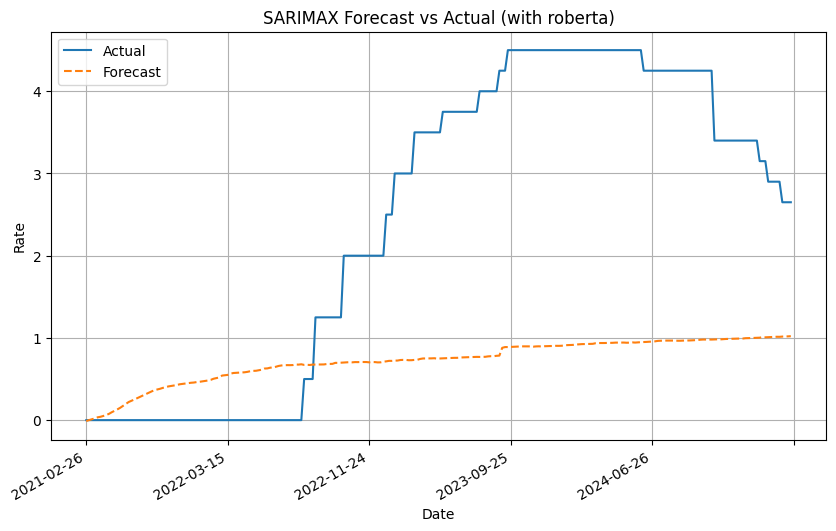

In [ ]:
predicted, actual, rmse, results= run_sarimax_diff(diff_df=differenced, levels_df=levels_with_roberta, target_name='current_rate', test_size=250)
print(f"RMSE (with roberta): {rmse}")
print(f"Model Summary (with roberta):\n{results.summary()}")
plot_forecast(actual, predicted, title='SARIMAX Forecast vs Actual (with roberta)')

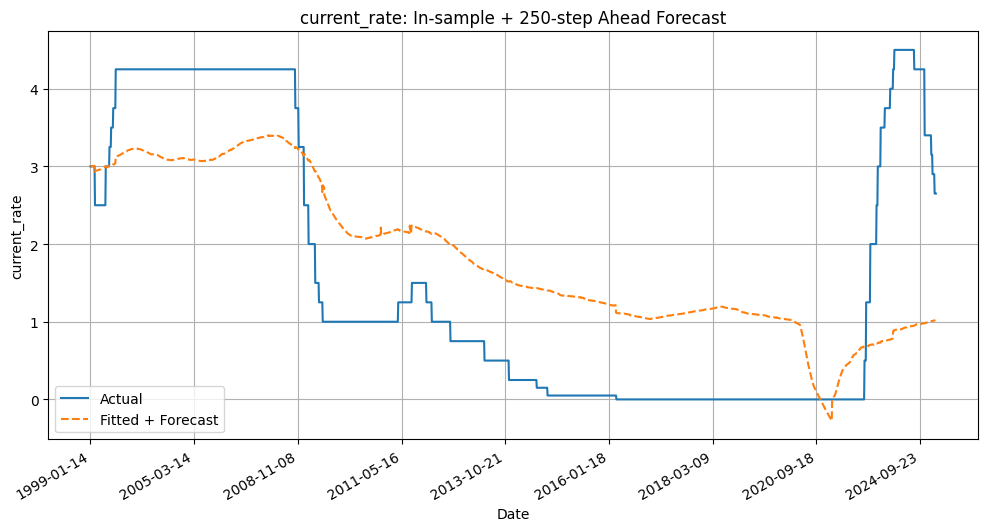

In [ ]:
def plot_full_model(levels_df, diff_df, results,
                    target_name='current_rate', test_size=350):
    """
    levels_df:  original DataFrame of levels, indexed by date
    diff_df:    the first‐differenced DataFrame (levels_df.diff().dropna())
    results:    the fitted SARIMAXResults object
    test_size:  number of steps held out for forecasting
    """
    # --- 1) In‐sample fitted differences
    fitted_diff = results.fittedvalues
    # seed with the very first observed level
    init_level = levels_df[target_name].iloc[0]
    # cumulative sum to recover fitted levels
    fitted_levels = init_level + fitted_diff.cumsum()
    fitted_levels.index = fitted_diff.index

    # --- 2) Out‐of‐sample forecasted differences
    # get last observed level before the test window
    last_level = levels_df[target_name].iloc[-test_size-1]
    # pick exog for the forecast period
    exog_vars = [c for c in diff_df.columns if c != target_name]
    exog_forecast = diff_df[exog_vars].iloc[-test_size:]
    # forecast diffs
    fcst_diff = results.get_forecast(steps=test_size,
                                     exog=exog_forecast).predicted_mean
    # recover levels
    fcst_levels = last_level + fcst_diff.cumsum()
    fcst_levels.index = levels_df.index[-test_size:]

    # --- 3) Combine fitted + forecast
    pred_full = pd.concat([fitted_levels, fcst_levels])

    # --- 4) Plot
    plt.figure(figsize=(12, 6))
    levels_df[target_name].plot(label='Actual')
    pred_full.plot(label='Fitted + Forecast', linestyle='--')
    plt.title(f'{target_name}: In-sample + {test_size}-step Ahead Forecast')
    plt.xlabel('Date')
    plt.ylabel(target_name)
    plt.legend()
    plt.grid(True)
    plt.gcf().autofmt_xdate()
    plt.show()

plot_full_model(
    levels_df=levels_with_roberta,
    diff_df=differenced,
    results=results,
    target_name='current_rate',
    test_size=250
)